<a href="https://colab.research.google.com/github/PUTIN-POMOGI/Create_db_faker/blob/master/Assingment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

### Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler


In [ ]:
df = pd.read_csv('Task 1.csv')

encoder = OneHotEncoder(sparse=False)
df['gender'] = encoder.fit_transform(pd.DataFrame(df['gender']))

encoder = OrdinalEncoder()
df['race/ethnicity'] = encoder.fit_transform(df['race/ethnicity'].values.reshape(-1,1))
df['parental level of education'] = encoder.fit_transform(df['parental level of education'].values.reshape(-1,1))
df['lunch'] = encoder.fit_transform(df['lunch'].values.reshape(-1,1))
df['test preparation course'] = encoder.fit_transform(df['test preparation course'].values.reshape(-1,1))

scaler= StandardScaler()
df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']]=scaler.fit_transform(df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']])
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,-0.966559,-1.909268,-0.314310,0.730577,-1.408927,67,67,63
1,1.034598,0.741266,1.342861,-1.368782,0.709760,40,59,55
2,-0.966559,1.624777,0.790470,-1.368782,0.709760,59,60,50
3,-0.966559,-1.025756,-0.314310,0.730577,0.709760,77,78,68
4,-0.966559,1.624777,-1.419090,0.730577,-1.408927,78,73,68
...,...,...,...,...,...,...,...,...
995,-0.966559,-0.142245,-0.314310,0.730577,0.709760,73,70,65
996,-0.966559,0.741266,-1.419090,-1.368782,-1.408927,85,91,92
997,1.034598,-0.142245,1.342861,-1.368782,0.709760,32,35,41
998,1.034598,-0.142245,0.790470,0.730577,0.709760,73,74,82


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class CustomData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.y = torch.tensor(y).float()
        self.X = torch.tensor(X).float()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx, :]

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

batch_size=20


y= df.iloc[:, -3:].values
X= df.iloc[:, :-3].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=3)

train_dataset = CustomData(X_train, y_train)
test_dataset = CustomData(X_test, y_test) 

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

In [ ]:
data, label = next(iter(train_dataloader))
label.shape

torch.Size([20, 3])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, model=[]):
        super(Net, self).__init__()
        self.model = nn.Sequential(*model)


    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

functions = [nn.LeakyReLU()]
layers = [5, 50, 3]
insides =[]

for i in range(len(layers)-2):
  insides.append(nn.Linear(layers[i], layers[i+1]))
  insides.append(functions[i])
insides.append(nn.Linear(layers[-2], layers[-1]))


model = Net(insides).to(device)

print(model)

Net(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=50, out_features=3, bias=True)
  )
)


In [ ]:
epochs = 100
lr = 0.01
seed = 1
log_interval = 2


loss_fn = nn.MSELoss(reduction='mean')

In [ ]:
def train( model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze() 
        loss = loss_fn(output, target) 
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test( model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze() 
            test_loss += loss_fn(output, target).item() 

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(
        test_loss))

In [ ]:
import torch.optim as optim
from sklearn.metrics import mean_squared_error
optimizer = optim.Adam(model.parameters(), lr = lr)


for epoch in range(1, epochs + 1):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)



Train Epoch: 1 [0/700 (0%)]	Loss: 5080.129883
Train Epoch: 1 [40/700 (6%)]	Loss: 4336.768555
Train Epoch: 1 [80/700 (11%)]	Loss: 4887.481445
Train Epoch: 1 [120/700 (17%)]	Loss: 3748.533447
Train Epoch: 1 [160/700 (23%)]	Loss: 4673.793457
Train Epoch: 1 [200/700 (29%)]	Loss: 4569.145508
Train Epoch: 1 [240/700 (34%)]	Loss: 4203.434082
Train Epoch: 1 [280/700 (40%)]	Loss: 4612.157227
Train Epoch: 1 [320/700 (46%)]	Loss: 4764.685547
Train Epoch: 1 [360/700 (51%)]	Loss: 3467.738525
Train Epoch: 1 [400/700 (57%)]	Loss: 4235.203613
Train Epoch: 1 [440/700 (63%)]	Loss: 3637.958252
Train Epoch: 1 [480/700 (69%)]	Loss: 3889.682373
Train Epoch: 1 [520/700 (74%)]	Loss: 4416.789062
Train Epoch: 1 [560/700 (80%)]	Loss: 3698.027100
Train Epoch: 1 [600/700 (86%)]	Loss: 3537.059326
Train Epoch: 1 [640/700 (91%)]	Loss: 3187.570312
Train Epoch: 1 [680/700 (97%)]	Loss: 2951.754395

Test set: Average loss: 171.6115

Train Epoch: 2 [0/700 (0%)]	Loss: 3403.845947
Train Epoch: 2 [40/700 (6%)]	Loss: 3185.508

In [ ]:
y_pred_nn = model(torch.tensor(X_test).float()) 
print("MSE neural network", mean_squared_error(y_test, y_pred_nn.detach().numpy()))

MSE neural network 166.1575547703153


### Questions
1. What preprocessing techniques did you use? Why?
    - *Answer*
2. Describe the fine-tuning process and how you reached your model architecture.
    - *Answer*

# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/ML/triple_mnist.zip" 

In [3]:
import torchvision
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np
import random


In [4]:
class MyImageFolder(torchvision.datasets.ImageFolder):
   def __init__(self, root,transform=None, target_transform=None):
       super().__init__(root,transform,target_transform)

   def find_classes(self, directory: str):
       idx_list, idx_dict = super().find_classes(directory)
       idx_dict = {i: int(i) for i in idx_dict}
       return idx_list, idx_dict


In [7]:
class CustomImageData(Dataset):
    def __init__(self, images, targets):
        super().__init__()
        
        for idx, image in enumerate(images):
          gray_img = np.array(image)
          images[idx] = rgb2gray(gray_img)
        
        self.images = images
        self.targets = targets

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.targets[idx]

In [8]:
train_dataset = MyImageFolder(root='./triple_mnist/train')

images =[]
classes =[]
for image, label in train_dataset:
  images.append(image)
  classes.append(label)

train_dataset = CustomImageData(images, classes)



In [28]:
class ImageRestorator:
    def __init__(self, dataset: CustomImageData):
      self.digits=[]
      for i in range(10):
        self.digits.append(get_img_cut(dataset, i))
      


    def recollect_digits(self, dataset: CustomImageData):
      self.digits=[]
      for i in range(10):
        self.digits.append(get_img_cut(dataset, i))

    def get_img_cut(dataset: CustomImageData, digit):
      length = len(dataset.targets)
      cuted_part =[]
      for i in range(100):
        idx = random.randint(0, length-1)
        img, target = dataset[idx]
        while (target % 10 != digit):
          idx+=100
          if idx >= length:
            idx = idx % length
          img, target = dataset[idx]
        cuted_part.append(img[:, 56:84])
      return cuted_part

    def class_restoration(self, res_cl: int):
      fir_d = res_cl // 100 #first digit of the class
      sec_d = (res_cl // 10) % 10
      thir_d = res_cl % 10
      fir_part = self.digits[fir_d]
      sec_part = self.digits[sec_d]
      thir_part = self.digits[thir_d]
      new_class_img =[]
      for i in range(len(fir_part)):
        image = np.concatenate((fir_part[i], sec_part[i], thir_part[i]), axis=1)
        new_class_img.append(image)
      return new_class_img

    def dataset_restoration(dataset: CustomImageData):
        classes = np.unique(dataset.targets)
        possible_classes = [i for i in range(1000)]
        lost_classes = list(set(possible_classes) - set(classes))
        images = []
        classes =[]
        for lost_class in lost_classes:
          images+= class_restoration(dataset, lost_class)
          classes+= [lost_class for i in range(100)]
        return CustomImageData(images, classes)

In [29]:
def dataset_restoration(dataset: CustomImageData):
    classes = np.unique(dataset.targets)
    possible_classes = [i for i in range(1000)]
    lost_classes = list(set(possible_classes) - set(classes))
    images = []
    classes =[]
    for lost_class in lost_classes:
      images+= class_restoration(dataset, lost_class)
      classes+= [lost_class for i in range(100)]
    return CustomImageData(images, classes)

def get_img_cut(dataset: CustomImageData, digit):
    length = len(dataset.targets)
    cuted_part =[]
    for i in range(100):
      idx = random.randint(0, length-1)
      img, target = dataset[idx]
      while (target % 10 != digit):
        idx+=100
        if idx >= length:
          idx = idx % length
        img, target = dataset[idx]
      cuted_part.append(img[:, 56:84])
    return cuted_part


def class_restoration(dataset: CustomImageData, res_cl: int):
    fir_d = res_cl // 100 #first digit of the class
    sec_d = (res_cl // 10) % 10
    thir_d = res_cl % 10
    fir_part = get_img_cut(dataset, fir_d)
    sec_part = get_img_cut(dataset, sec_d)
    thir_part = get_img_cut(dataset, thir_d)
    new_class_img =[]
    for i in range(len(fir_part)):
      image = np.concatenate((fir_part[i], sec_part[i], thir_part[i]), axis=1)
      new_class_img.append(image)
    return new_class_img

#res_data = dataset_restoration(train_dataset)
imgres = ImageRestorator(train_dataset)

resu = imgres.class_restoration(176)
print(resu[0].shape)

TypeError: ignored

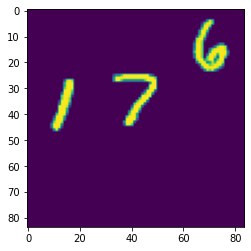

In [23]:
plt.imshow(resu[0])
plt.show()

In [ ]:
img = class_restoration(train_dataset, 456)

figure = plt.figure(figsize=(10, 8))
columns =25
rows = 4
for i in range(1, columns * rows ):
    figure.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(img[i], cmap="gray")
plt.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

### Questions
1. What preprocessing techniques did you use? Why?
    - *Answer*
2. What data augmentation techniques did you use?
    - *Answer*
3. Describe the fine-tuning process and how you reached your final CNN model.
    - *Answer*

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

In [ ]:

df = pd.read_csv('loan_data.csv')

encoder = OrdinalEncoder()
df['purpose'] = encoder.fit_transform(df['purpose'].values.reshape(-1,1))

y = df.iloc[:,0]
X = df.iloc[:, 1:]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

dt_clf = DecisionTreeClassifier(criterion = "entropy")
dt_clf = dt_clf.fit(train_x, train_y)


score = dt_clf.score(test_x, test_y)
print(score)

0.9900835073068893


### Questions
1. How did the DT compare to the RF in performance? Why?
    - *Answer*
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - *Answer*
3. What is ensemble learning? What are its pros and cons?
    - *Answer*
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - *Answer*

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [ ]:
# TODO: Implement task 4

### Questions
1. How did your model perform? Why is it better/worse?
    - *Answer*
2. What is domain gap in the context of ML?
    - *Answer*
3. Suggest two ways through which the problem of domain gap can be tackled.
    - *Answer*